In [34]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [113]:
class celia_EulerBDiff:
    
    def __init__(self):
        
        self.alpha = 1.611e6
        self.phi = 0.287
        self.theta_r = 0.075
        self.beta = 3.96
        self.Ks = 0.00944
        self.A = 1.175e6
        self.gamma = 4.74
        self.psi0 = -61.5
        self.psiT = -20.7
        self.psiB = -61.5
        
        self.dt = 1
        self.dz = 1
        self.H = 40
        self.t = [0, 360]
        
    def get_C(self, psi):
        
        alpha = self.alpha
        phi = self.phi
        theta_r = self.theta_r
        beta = self.beta
        
        x1 = alpha * (phi - theta_r)
        x2 = (alpha + np.abs(psi) ** beta) ** 2
        x3 = beta * np.abs(psi) ** (beta -1)
        
        C =  x1 / x2 * x3
        
        return C
    
    def get_K(self, psi):
        
        A = self.A
        gamma = self.gamma
        Ks = self.Ks
        
        K = Ks * A / (A + np.abs(psi) ** gamma)
        
        return K
    
    def get_theta(self, psi):
        
        alpha = self.alpha
        phi = self.phi
        theta_r = self.theta_r
        beta = self.beta
        
        x1 = alpha * (phi - theta_r)
        x2 = alpha + np.abs(psi) ** beta
        
        theta =  x1/x2 + theta_r
        
        return theta
    
    def solver(self, psi, n, C, Kmid):
        
        dt = self.dt
        dz = self.dz
        psiT = self.psiT
        psiB = self.psiB
        
        # initialize arrays
        a = np.zeros(n)
        b = np.zeros(n)
        c = np.zeros(n)
        d = np.zeros(n)
        
        a = -dt/C*Kmid[:-1]/dz**2
        c = -dt/C*Kmid[1:]/dz**2
        b = 1-a-c
        d = psi - dt/(C*dz)*(Kmid[1:]-Kmid[:-1])
        
        # Boundary conditions
        d[0] = d[0] - a[0]*psiT
        d[-1] = d[-1] - c[-1]*psiB
        
        # Tridiagonal matrix
        M = np.diag(a[1:],-1) + np.diag(b,0) + np.diag(c[:-1],1)
        
        # Solve
        psi_new = np.linalg.solve(M, d)

        return psi_new
        
    def solve(self):
        
        dz = self.dz
        dt = self.dt
        H = self.H
        t0, tM = self.t
        psi0 = self.psi0
        psiT = self.psiT
        psiB = self.psiB
        
        z = np.arange(dz, H, dz)
        t = np.arange(t0, tM + dt, dt)
        
        n = len(z)
        nt = len(t)
        
        psi_ini = np.ones(n) * psi0
        psi_list = [np.hstack([psi0, psi_ini, psi0])]
        theta_list = [self.get_theta(np.hstack([psi0, psi_ini, psi0]))]
        K_list = []
        
        for j in range(1, nt):
            
            K = self.get_K(np.hstack([psiT, psi_ini, psiB]))
            C = self.get_C(psi_ini)
            Kmid = (K[:-1] + K[1:])/2
            
            psi_out = self.solver(psi_ini, n, C, Kmid)
            
            psi_list = psi_list + [np.hstack([psiT, psi_out, psiB])]
            theta_list = theta_list + [self.get_theta(np.hstack([psiT, psi_out, psiB]))]
            
            psi_ini = psi_out
            K_list = K_list + [K]
        
        ret = {'z' : -np.hstack([0, z, H]),
               't' : t,
               'psi' : np.array(psi_list),
               'theta': np.array(theta_list),
               'K' : np.array(K_list)}
        
        return ret

In [140]:
# Run model

model = celia_EulerBDiff()
model.dt = 0.1

out = model.solve()

# Get output
psi = out['psi']
theta = out['theta']
K = out['K']
z = out['z']
t = out['t']

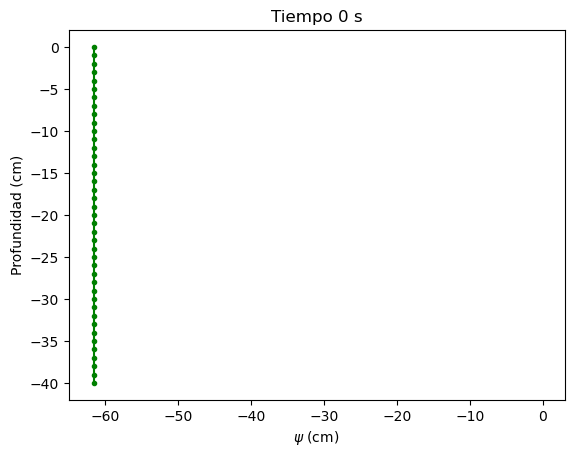

In [141]:
fig, ax = plt.subplots()
line1 = ax.plot(psi[0,:], z, 'g.-')[0]
ax.set(ylim=[-42, 2], xlim=[-65, 3], ylabel='Profundidad (cm)', xlabel='$\psi$ (cm)')
ax.set_title(f'Tiempo {0} s') 
plt.show()

In [142]:
def update(frame):
    # update the line plot:
    line1.set_xdata(psi[frame,:])
    ax.set_title(f'Tiempo {frame*model.dt: 3.0f} s')
    return (line, ax)

anim = animation.FuncAnimation(fig=fig, func=update, frames=len(t), interval=5)
HTML(anim.to_html5_video())